In [1]:
!git clone https://github.com/saurabh-m-w/Self-Car-Driving-Track

Cloning into 'Self-Car-Driving-Track'...
remote: Enumerating objects: 12163, done.
remote: Total 12163 (delta 0), reused 0 (delta 0), pack-reused 12163
Receiving objects: 100% (12163/12163), 156.98 MiB | 35.75 MiB/s, done.
Checking out files: 100% (12160/12160), done.


In [2]:
!ls Self-Car-Driving-Track

driving_log.csv  IMG


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import keras
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
import cv2
import pandas as pd
import random
import ntpath
from sklearn.utils import shuffle

In [ ]:
import tensorflow
print(tensorflow.__version__)

2.3.0


In [4]:
datadir = 'Self-Car-Driving-Track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


center  ...     speed
0  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

In [5]:
def path_leaf(path):
  head,tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center  ...     speed
0  center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

In [6]:
num_bins = 25
hist, bins = np.histogram(data['steering'], num_bins)
print(bins)    #stering angles

[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


<BarContainer object of 25 artists>

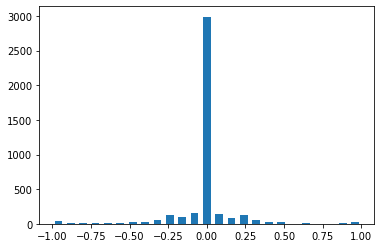

In [7]:
center = (bins[:-1]+bins[1:])*0.5
plt.bar(center,hist,width=0.05)

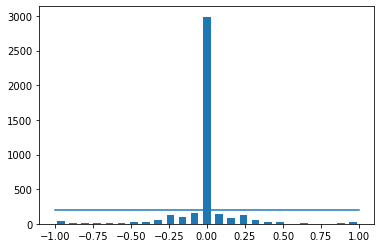

In [8]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [9]:
print('total data:',len(data))
remove_list=[]
for j in range(num_bins):
  list_=[]
  for i in range(len(data['steering'])):
    if data['steering'][i]>=bins[j] and data['steering'][i]<=bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
print('removed: ',len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

total data: 4053
removed:  2790
remaining: 1263


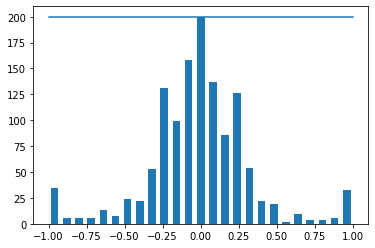

In [10]:
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [11]:
print(data.iloc[1])

center      center_2018_07_16_17_11_44_485.jpg
left        left_2018_07_16_17_11_44_485.jpg  
right       right_2018_07_16_17_11_44_485.jpg 
steering   -0.25                              
throttle    0.863326                          
reverse     0                                 
speed       2.17305                           
Name: 13, dtype: object


In [12]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [132]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 1010
Valid Samples: 253


Text(0.5, 1.0, 'Validation set')

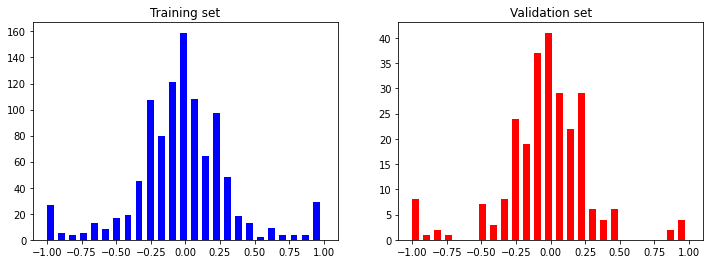

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

#Data Augmentation

In [15]:
from imgaug import augmenters as iaa
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

In [16]:

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

Text(0.5, 1.0, 'Zoomed Image')

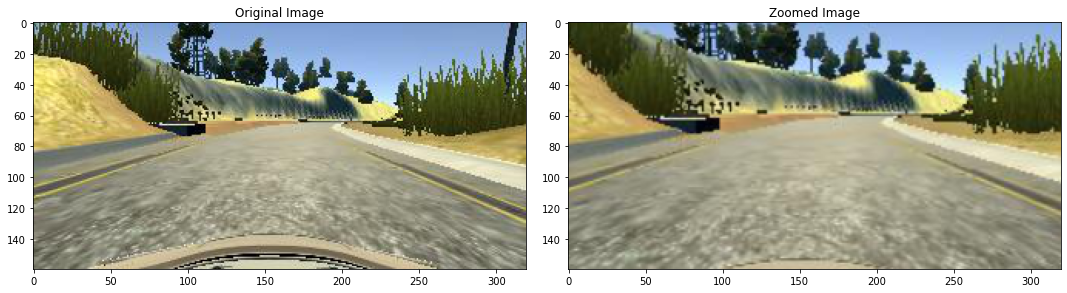

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')


In [18]:
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image


In [19]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

Text(0.5, 1.0, 'Panned Image')

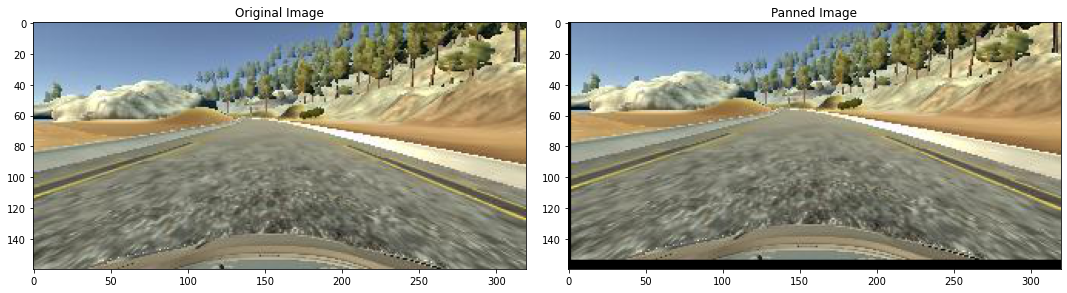

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

In [22]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

In [23]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightn_image = img_random_brightness(original_image)

Text(0.5, 1.0, 'Brightness changed image ')

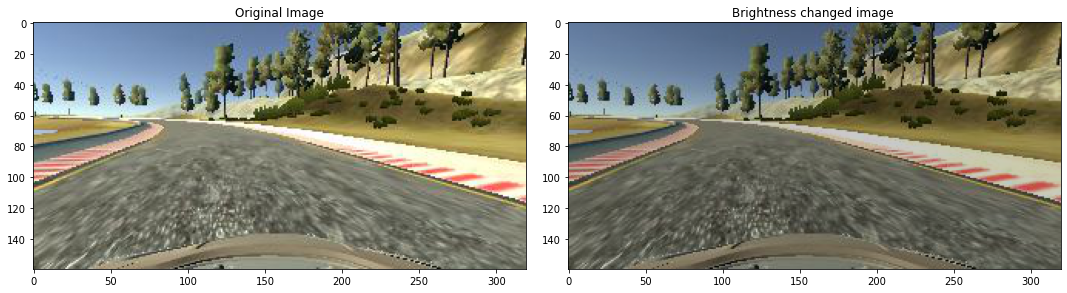

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brightn_image)
axs[1].set_title('Brightness changed image ')

In [25]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

In [26]:
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

In [27]:
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

Text(0.5, 1.0, 'Flipped Image')

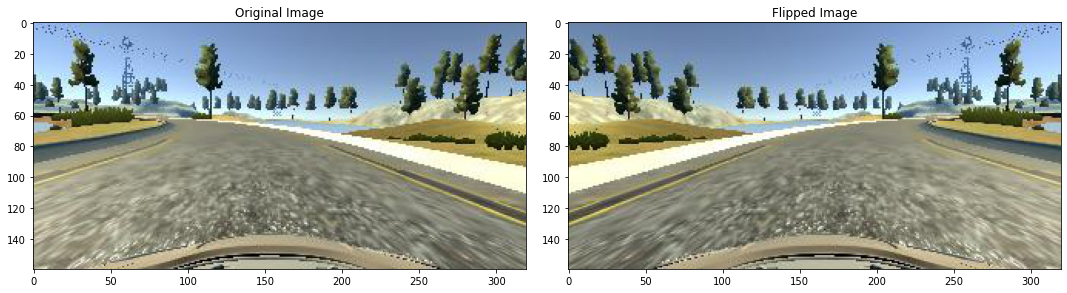

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image')

In [29]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:    
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle

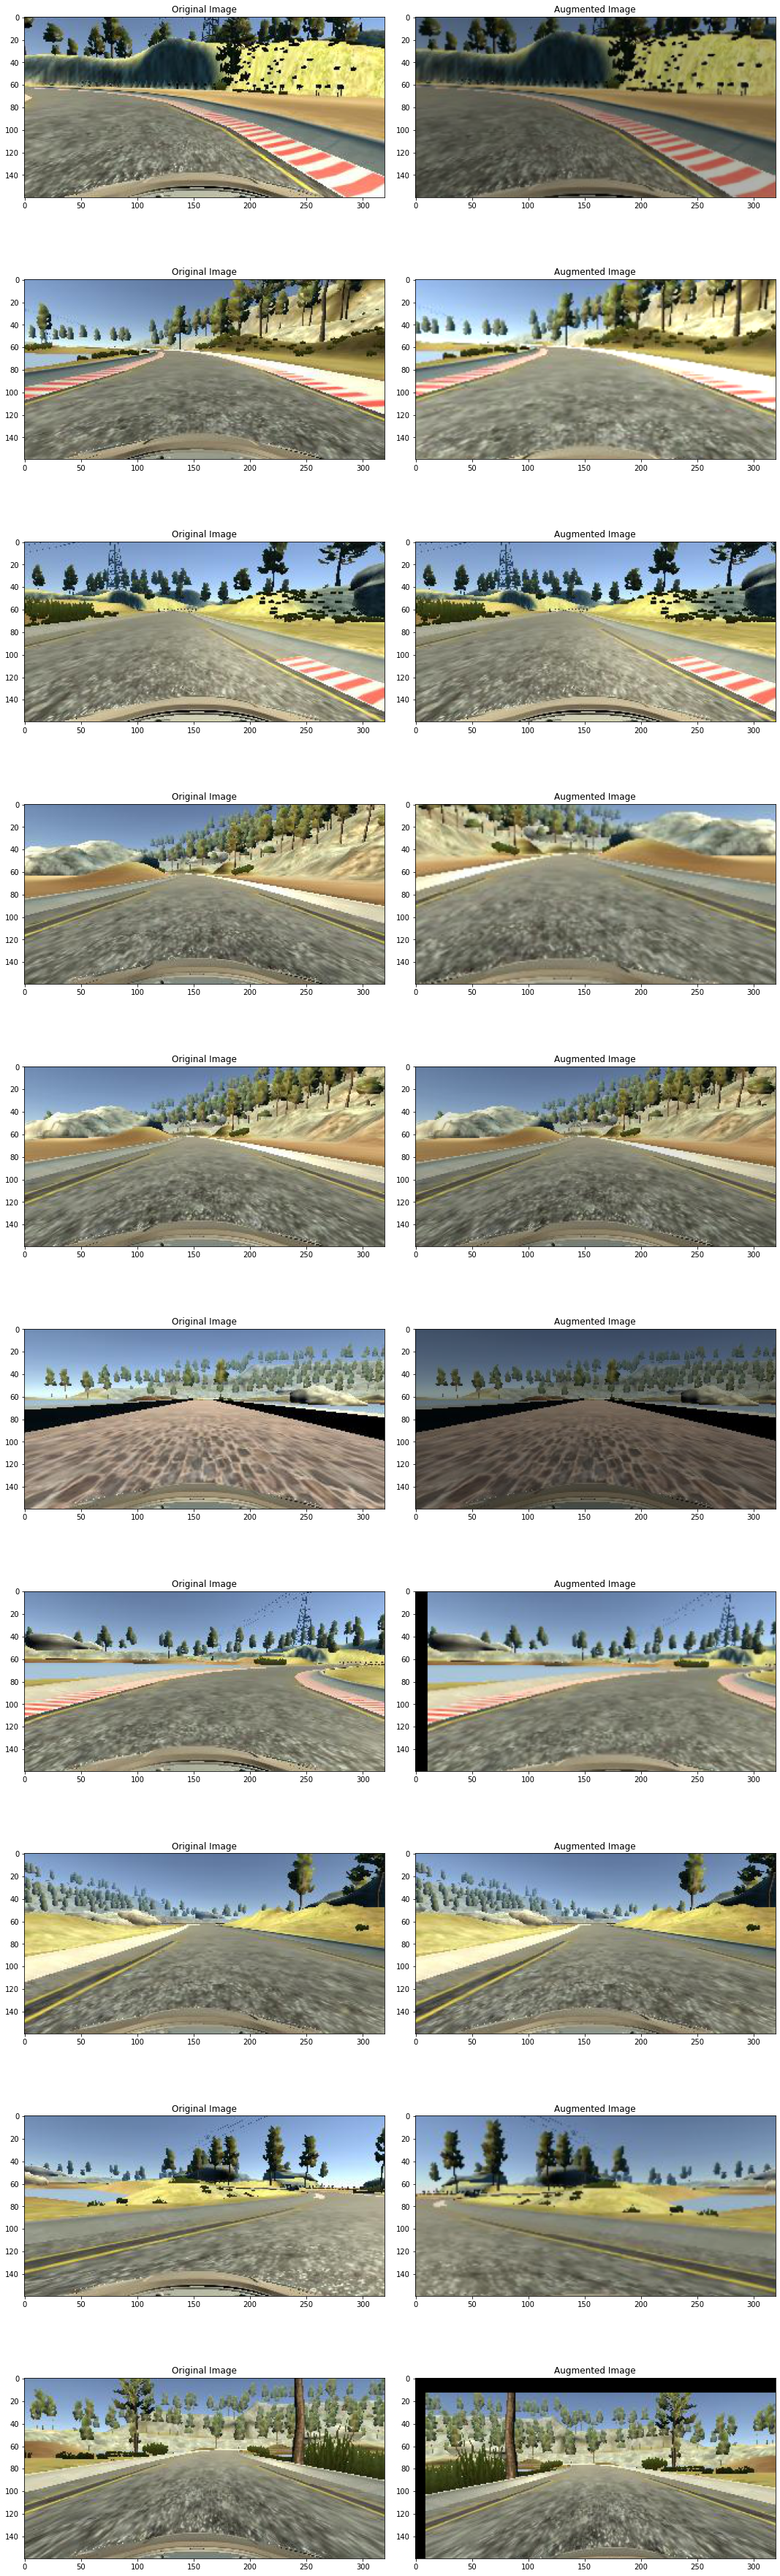

In [30]:
fig, axs = plt.subplots(10, 2, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

In [120]:
def img_preprocess(img):
    #img = mpimg.imread(img)
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

Text(0.5, 1.0, 'Preprocessed Image')

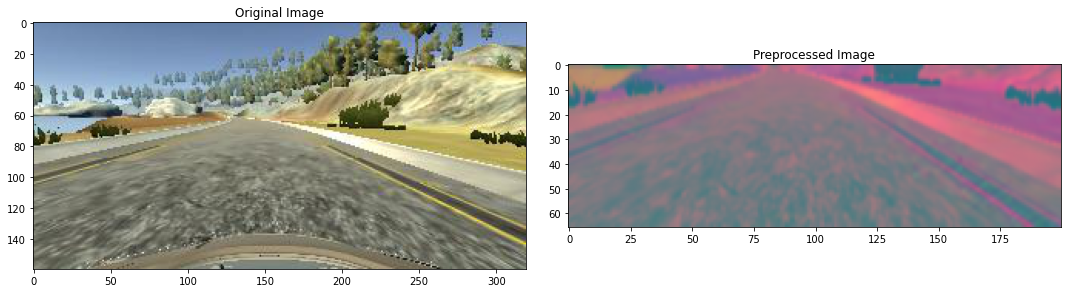

In [121]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [122]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering)) 

In [124]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

Text(0.5, 1.0, 'Validation Image')

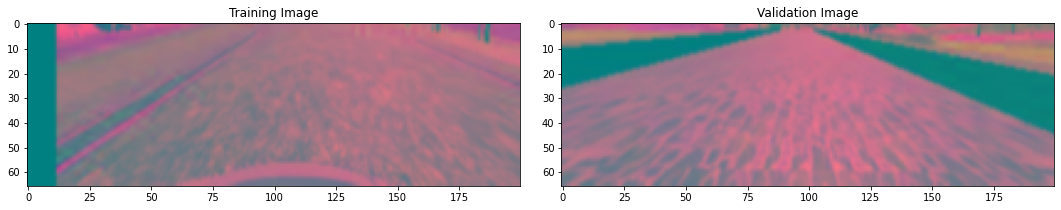

In [125]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [127]:
def img_preprocess2(img):
    img=mpimg.imread(image)
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

In [128]:
#X_train = np.array(list(map(img_preprocess2, X_train)))
#X_valid = np.array(list(map(img_preprocess2, X_valid)))

(1010, 66, 200, 3)


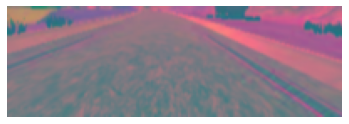

In [129]:
plt.imshow(X_train[random.randint(0,len(X_train)-1)])
plt.axis('off')
print(X_train.shape)

In [130]:

def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, 5, 2, input_shape = (66, 200, 3), activation = 'elu'))
  model.add(Convolution2D(36, 5, 2, activation = 'elu'))
  model.add(Convolution2D(48, 5, 2, activation = 'elu'))
  model.add(Convolution2D(64, 3, activation = 'elu'))
  model.add(Convolution2D(64, 3, activation = 'elu'))
#   model.add(Dropout(0.5))
  
  
  model.add(Flatten())
  
  model.add(Dense(100, activation = 'elu'))
#   model.add(Dropout(0.5))
  
  model.add(Dense(50, activation = 'elu'))
#   model.add(Dropout(0.5))
  
  model.add(Dense(10, activation = 'elu'))
#   model.add(Dropout(0.5))

  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model


In [131]:
model = nvidia_model()
print(model.summary())


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_9 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 100)             

In [133]:
history = model.fit(batch_generator(X_train, y_train, 100, 1),epochs=30,validation_data=batch_generator(X_valid, y_valid, 100, 0),batch_size=100,verbose=1,shuffle=1)

Epoch 1/30
     81/Unknown - 96s 1s/step - loss: 0.2002

KeyboardInterrupt: ignored

In [134]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Epoch 1/10
300/300 [==============================] - 437s 1s/step - loss: 0.0780 - val_loss: 0.0490
Epoch 2/10
300/300 [==============================] - 434s 1s/step - loss: 0.0597 - val_loss: 0.0391
Epoch 3/10
300/300 [==============================] - 439s 1s/step - loss: 0.0505 - val_loss: 0.0329
Epoch 4/10
300/300 [==============================] - 446s 1s/step - loss: 0.0439 - val_loss: 0.0345
Epoch 5/10
300/300 [==============================] - 445s 1s/step - loss: 0.0404 - val_loss: 0.0359
Epoch 6/10
300/300 [==============================] - 437s 1s/step - loss: 0.0380 - val_loss: 0.0263
Epoch 7/10
300/300 [==============================] - 431s 1s/step - loss: 0.0374 - val_loss: 0.0315
Epoch 8/10
300/300 [==============================] - 436s 1s/step - loss: 0.0346 - val_loss: 0.0230
Epoch 9/10
300/300 [==============================] - 434s 1s/step - loss: 0.0334 - val_loss: 0.0208
Epoch 10/10
300/300 [==============================] - 435s 1s/step - loss: 0.0327 - val_lo

Text(0.5, 0, 'Epoch')

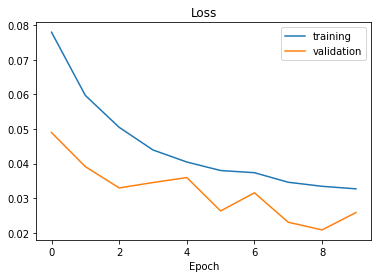

In [135]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [136]:
model.save('model.h5')

In [137]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>